In [16]:
import json
import gzip
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D
import matplotlib as mpl
from itertools import product
import json
import os

In [2]:
def get_measurements_combinations(deltas_plus, deltas_min):
    return list(product(deltas_plus, deltas_min))

def df_to_delta(df):
    slip_factor = 0.0017935055033301713
    f = 200_000_000
    return 1/slip_factor * df/f

def interpolate_50_val(xvals, yvals):
    if np.any(yvals <= 0.5):  # ensure the curve actually crosses 0.5
        idx_above = np.where(yvals > 0.5)[0][-1]   # last index above 0.5
        idx_below = idx_above + 1                  # first index below 0.5

        # Linear interpolation for more accuracy
        x50 = np.interp(0.5, [yvals[idx_above], yvals[idx_below]],
                            [xvals[idx_above], xvals[idx_below]])
        return x50
    else:
        print("Warning: The curve does not cross 0.5")
        return None
    
def get_acceptance_and_center(delta_plus, delta_minus):
    if delta_plus is None or delta_minus is None:
        return None
    center = 0.5 * (delta_plus + delta_minus)
    acceptance = delta_plus - delta_minus
    return center, acceptance

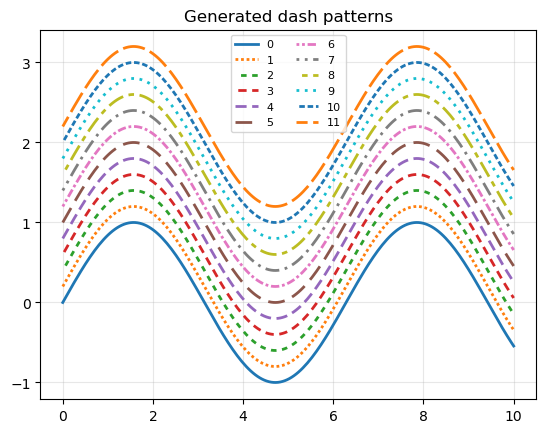

In [14]:
def generate_distinct_dashes(
    n: int,
    *,
    min_on: float = 1.0,
    max_on: float = 10.0,
    min_off: float = 1.0,
    max_off: float = 10.0,
    include_solid: bool = True,
):
    """
    Generate `n` visually distinct linestyles for Matplotlib.

    Returns a list of linestyles usable as `linestyle=...` in ax.plot:
      - "-" for solid (optional)
      - dash tuples of the form (offset, (on, off, on, off, ...))

    The patterns are built from a small set of base "motifs" and scaled/offset
    so they remain distinguishable without becoming too chaotic.
    """
    if n <= 0:
        return []

    styles = []
    if include_solid:
        styles.append("-")
        if n == 1:
            return styles
        n_remaining = n - 1
    else:
        n_remaining = n

    # Base motifs: dashed, dotted, dash-dot, long-short, etc.
    motifs = [
        (1, 1),           # dotted
        (2, 2),           # short dashed
        (3, 2),           # medium dash
        (4, 2),           # longer dash
        (6, 3),           # long dash
        (3, 1, 1, 1),     # dash-dot (tight)
        (5, 2, 1, 2),     # dash-dot (looser)
        (6, 2, 2, 2),     # long-short
        (1, 2),           # sparse dots
        (2, 1),           # dense dashes
        (8, 2),           # very long dash
        (2, 2, 6, 2),     # two-dash motif
    ]

    # Choose scale factors so patterns spread out but stay readable
    # Use a quasi-log spacing (helps keep early patterns distinct).
    scales = np.geomspace(1.0, 2.5, num=max(1, int(np.ceil(n_remaining / len(motifs)))))
    offsets = np.linspace(0.0, 6.0, num=max(2, int(np.ceil(n_remaining / 3))))  # small phase offsets

    def clamp(v, lo, hi):
        return float(np.clip(v, lo, hi))

    k = 0
    for s in scales:
        for motif in motifs:
            if k >= n_remaining:
                break

            # Scale motif and clamp to keep it within sensible dash lengths
            scaled = []
            for i, v in enumerate(motif):
                if i % 2 == 0:  # "on"
                    scaled.append(clamp(v * s, min_on, max_on))
                else:           # "off"
                    scaled.append(clamp(v * s, min_off, max_off))

            offset = float(offsets[k % len(offsets)])
            styles.append((offset, tuple(scaled)))
            k += 1

        if k >= n_remaining:
            break

    return styles


# ---------------- Example usage ----------------
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    x = np.linspace(0, 10, 200)
    styles = generate_distinct_dashes(12, include_solid=True)

    fig, ax = plt.subplots()
    for i, ls in enumerate(styles):
        ax.plot(x, np.sin(x) + i * 0.2, linestyle=ls, linewidth=2, label=f"{i}")
    ax.set_title("Generated dash patterns")
    ax.legend(ncol=2, fontsize=8)
    ax.grid(alpha=0.3)
    plt.show()


In [15]:
styles

['-',
 (0.0, (1.0, 1.0)),
 (2.0, (2.0, 2.0)),
 (4.0, (3.0, 2.0)),
 (6.0, (4.0, 2.0)),
 (0.0, (6.0, 3.0)),
 (2.0, (3.0, 1.0, 1.0, 1.0)),
 (4.0, (5.0, 2.0, 1.0, 2.0)),
 (6.0, (6.0, 2.0, 2.0, 2.0)),
 (0.0, (1.0, 2.0)),
 (2.0, (2.0, 1.0)),
 (4.0, (8.0, 2.0))]

In [3]:
path_MD_data = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/')
path_study_results = Path("/Users/lisepauwels/sps_simulations/Studies/MomentumAcceptance/IntensityScan2/study_results")
name_files = [p.name for p in path_study_results.iterdir()]

In [4]:
sweep_per_turn = 1.0
data_simulations = {'linear' : {}, 'errors': {}}
for name_file in name_files:
    with gzip.open(path_study_results / name_file, "rt") as f:
        study_results = json.load(f)

    line_type = name_file.split("_")[1]
    chroma = float(name_file.split("_")[2].split(".json")[0])
    print(line_type, chroma)
    if chroma not in data_simulations[line_type]:
        data_simulations[line_type][chroma] = {}
    
    for plane in list(study_results.keys()):
        assert abs(study_results[plane]['sweep_per_turn']) == sweep_per_turn
        turns, counts = np.unique(study_results[plane]['at_turn'], return_counts=True)
        data_simulations[line_type][chroma][plane] = {'turns' : turns, 'counts' : counts}

errors 0.1
linear -0.2
errors -0.1
linear 0.3
errors -1.5
errors 1.5
linear 1.1
errors -0.7
linear 0.8
errors 0.7
linear -0.4
errors 1.3
linear -1.0
linear 0.5
linear -0.9
errors -1.3
linear -0.3
errors 0.0
errors -1.4
linear 0.2
errors 1.4
errors -0.6
linear 1.0
linear -0.5
linear 0.9
errors 0.6
linear -1.1
errors 1.2
errors -1.2
linear -0.8
linear 0.4
linear 1.5
errors -0.3
errors 0.3
linear -1.4
linear 0.1
errors 0.5
linear -0.6
linear 1.3
errors -0.5
linear 0.7
errors 0.8
errors -1.1
errors 1.1
errors -0.8
linear -1.2
errors -0.2
linear 1.4
linear -0.1
errors 0.2
linear -1.5
linear 0.0
linear -0.7
errors 0.4
errors -0.4
linear 1.2
errors -1.0
linear 0.6
errors 0.9
linear -1.3
errors -0.9
errors 1.0


In [11]:
normalised_intensity = {}
num_particles = 2000 * 500
for line_type in ['linear', 'errors']:
    normalised_intensity[line_type] = {}
    for chroma in sorted(data_simulations[line_type].keys()):
        normalised_intensity[line_type][chroma] = {}
        for plane in ['DPpos', 'DPneg']:
            turns = data_simulations[line_type][chroma][plane]['turns']
            counts = data_simulations[line_type][chroma][plane]['counts']

            turns = np.concatenate(([0], turns))
            counts = np.concatenate(([0], counts))

            deltas = df_to_delta(turns * sweep_per_turn)
            if plane == 'DPneg':
                deltas = -deltas
            
            normalised_intensity[line_type][chroma][plane] = {'deltas': deltas, 'values': 1 - np.cumsum(counts) / num_particles}

# Intensity plots

In [38]:
def chroma_to_color(cmap, norm, chroma):
    return cmap(norm(chroma))

def plot_intensity_drop(normalised_intensity, line_types=None, chromas=None, line_styles=None, cmap=None, savefig=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if line_types is None:
        line_types = list(normalised_intensity.keys())
    if chromas is None:
        chromas = list(normalised_intensity[line_types[0]])

    if line_styles is None:
        line_styles = {}
        if len(line_types) <= 4:
            ls_basic = ['-', '--', '-.', ':']
            for i, lt in enumerate(line_types):
                line_styles[lt] = ls_basic[i]
        else:
            styles = generate_distinct_dashes(len(line_types), include_solid=True)
            for i, lt in enumerate(line_types):
                line_styles[lt] = styles[i]
    
    if cmap is None:
        cmap = colormaps['coolwarm']
    
    all_chromas = sorted({ch for lt in normalised_intensity for ch in normalised_intensity[lt].keys()})
    vmin, vmax = min(all_chromas), max(all_chromas)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for lt in line_types:
        for c in chromas:
            for plane in ['DPpos', 'DPneg']:
                ax.plot(
                    normalised_intensity[lt][c][plane]['deltas'],
                    normalised_intensity[lt][c][plane]['values'],
                    color=chroma_to_color(cmap, norm, c),
                    linestyle=line_styles[lt],
                )
    
    line_handles = [
        Line2D([0], [0], color='black', linestyle=line_styles[lt], linewidth=2, label=lt)
        for lt in line_styles
    ]
    legend_model = ax.legend(handles=line_handles, title="Model", loc="upper left", frameon=True)
    ax.add_artist(legend_model)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required by older mpl for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("Chromaticity  $Q'_x$")

    ax.set_xlabel(r"$\delta$")
    ax.set_ylabel('Normalised Intensity Loss')
    ax.grid()
    fig.tight_layout()

    if savefig is not None:
        figures_path = os.path.join(os.getcwd(), "Figures")

        if os.path.isdir(figures_path):
            plt.savefig(os.path.join(figures_path, savefig), dpi=300)
        else:
            plt.savefig(savefig, dpi=300)
    
    return fig, ax

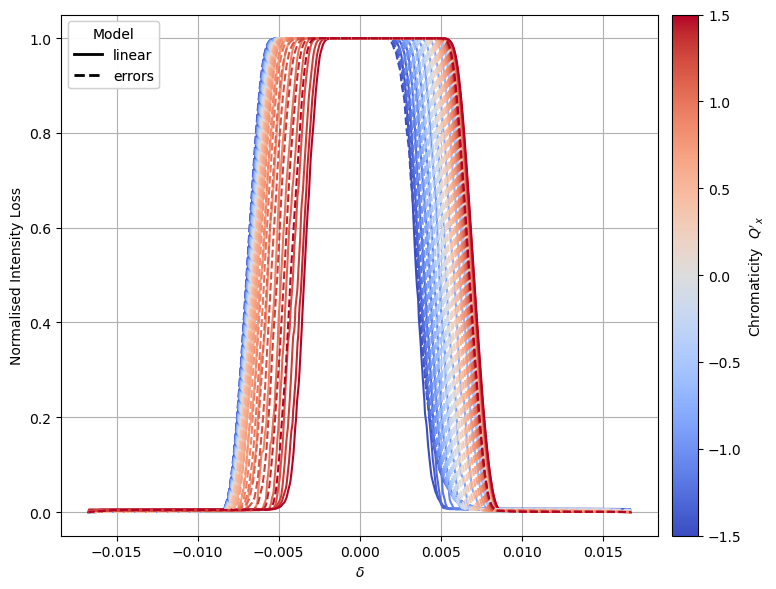

In [39]:
fig, ax = plot_intensity_drop(normalised_intensity, savefig='IntensityLoss_all.png')

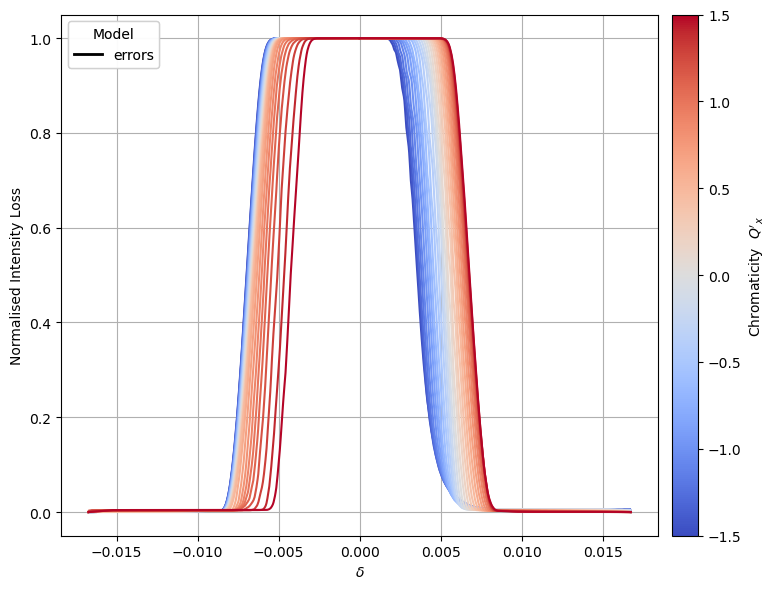

In [40]:
fig, ax = plot_intensity_drop(normalised_intensity, line_types=['errors'], savefig='IntensityLoss_errors.png')

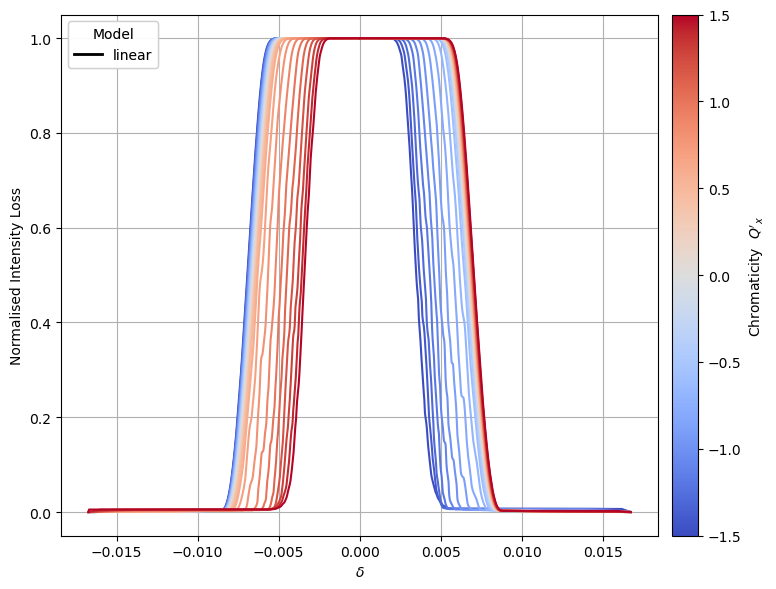

In [41]:
fig, ax = plot_intensity_drop(normalised_intensity, line_types=['linear'], savefig='IntensityLoss_wo_errors')

# Midpoints, acceptances, centers

In [42]:
def get_midpoints(normalised_intensity, sim_data=True):
    intensity_midpoints = {}
    if sim_data:
        for lt in normalised_intensity:
            intensity_midpoints[lt] = {}
            for c in normalised_intensity[lt]:
                intensity_midpoints[lt][c] = {}
                for plane in normalised_intensity[lt][c]:
                    deltas = normalised_intensity[lt][c][plane]['deltas']
                    values = normalised_intensity[lt][c][plane]['values']

                    x50 = interpolate_50_val(deltas, values)
                    intensity_midpoints[lt][c][plane] = x50
    
    else:
        pass
    
    return intensity_midpoints

In [44]:
def get_acceptance(delta_plus, delta_min):
    return delta_plus - delta_min

def get_center(delta_plus, delta_min):
    return 0.5 * (delta_plus + delta_min)

def get_measurements_combinations(deltas_plus, deltas_min):
    return list(product(deltas_plus, deltas_min))

In [47]:
def restructure_md_midpoints(md_midpoints_old):
    md_midpoints = {}
    for chroma_val in md_midpoints_old[list(md_midpoints_old.keys())[0]]:
        chroma = float(chroma_val.split('_')[-1])
        md_midpoints[chroma] = {}

    for sign in md_midpoints_old:
        if sign == 'pos':
            plane = 'DPpos'
        elif sign == 'neg':
            plane = 'DPneg'
        else:
            print('Unvalid sign !')
            AssertionError
        for chroma_val in md_midpoints_old[sign]:
            chroma = float(chroma_val.split('_')[-1])
            md_midpoints[chroma][plane] = md_midpoints_old[sign][chroma_val]
    
    return md_midpoints

In [50]:
with open(path_MD_data/'midpoints_MD.json') as f:
    midpoints_md_old = json.load(f)

In [51]:
midpoints_md = restructure_md_midpoints(md_midpoints_old=midpoints_md_old)

In [52]:
midpoints_md

{0.5: {'DPpos': [0.0066685670404098354,
   0.0066224709548770464,
   0.0066224709548770464,
   0.0066224709548770464],
  'DPneg': [-0.005155823960015898,
   -0.005018090788153846,
   -0.005585530771604413,
   -0.005170725185333863]},
 0.7: {'DPpos': [0.006482033013314783,
   0.006714663125942623,
   0.006730028487786885],
  'DPneg': [-0.004659267621268116,
   -0.005111120284062003,
   -0.004977009256200316,
   -0.005006811706836247]},
 1.0: {'DPpos': [0.006437329337360889,
   0.006377724436089031,
   0.006511835463950714,
   0.006556539139904611],
  'DPneg': [-0.0040072418317028975,
   -0.004366059018163752,
   -0.0038985708667753603,
   -0.004440565144753577]}}

In [53]:
import colorsys
def random_distinct_colors(n, seed=None):
    rng = np.random.default_rng(seed)

    hues = np.linspace(0, 1, n, endpoint=False)
    rng.shuffle(hues)

    colors = []
    for h in hues:
        s = rng.uniform(0.6, 0.9)
        v = rng.uniform(0.7, 0.95)
        colors.append(colorsys.hsv_to_rgb(h, s, v))

    return colors

In [ ]:
# def plot_centers(intensity_midpoints, line_types=None, chromas=None, colours = None, markers = None, md_midpoints=None):
#     fig, ax = plt.subplots(1,1, figsize=(8,6))

#     if line_types is None:
#         line_types = list(normalised_intensity.keys())
#     if chromas is None:
#         chromas = list(normalised_intensity[line_types[0]])

#     if colours is None:
#         colours = {}
#         if md_midpoints is None:
#             colour_list = random_distinct_colors(len(line_types))
#         else:
#             colour_list = random_distinct_colors(len(line_types) + 2)
        
#         for i, lt in enumerate(line_types):
#             colours[lt] = colour_list[i]
#         if md_midpoints is not None: 
#             colours['MD_means'] = colour_list[-2]
#             colours['MD_stds'] = colour_list[-1]
    
#     if markers is None:
#         markers = {}
#         for lt in line_types:
#             markers[lt] = 'o'
        
#         if md_midpoints is not None:
#             markers['MD_data'] = "s"
#             markers['MD_means'] = 'o'
        
#     for lt in intensity_midpoints:
#         centers = []
#         chromas = []
#         for chroma in sorted(intensity_midpoints[line_type].keys()):
#             centers.append(get_center(intensity_midpoints[lt][chroma]['DPpos'], intensity_midpoints[lt][chroma]['DPneg']))
#             chromas.append(chroma)
    
#         ax.plot(chromas, centers, color = colours[lt], marker=markers[lt], linestyle='-', label=f'{lt}')

#     if md_midpoints is not None:
#         if list(md_midpoints.keys())[0] == 'pos' or list(md_midpoints.keys())[0] == 'neg':
#             AssertionError('md midpoints dictionary does not have the right structure ! Apply restructure_md_midpoints first !')
        
#         centers_md = {}
#         for c in md_midpoints:
#             combos = get_measurements_combinations(md_midpoints[c]['DPpos'], md_midpoints[c]['DPneg'])
#             centers_md[c] = {'mean' : 0, 'std' : 0, 'points' : []}
#             for [plus, min] in combos:
#                 centers_md[c]['points'].append(get_center(plus, min))
            
#             centers_md[c]['points'] = np.array(centers_md[c]['points'])
#             centers_md[c]['mean'] = np.mean(centers_md[c]['points'])
#             centers_md[c]['std'] = np.std(centers_md[c]['points'])


#         #plotting
#         chromas = np.array(list(centers_md.keys()))
#         print(chromas)
#         print([centers_md[c]['mean'] for c in chromas])
#         means = np.array([float(centers_md[c]['mean']) for c in chromas])
#         stds = np.array([float(centers_md[c]['std']) for c in chromas])

#         ax.plot(chromas, means, linestyle='-', marker=markers['MD_means'], color = colours['MD_means'], label = 'MD mean centers')
#         ax.fill_between(chromas, means-stds, means+stds, color = colours['MD_stds'], alpha=0.3, label = 'MD center spread')
#         xs = []
#         ys = []

#         for c, d in centers_md.items():
#             pts = d["points"]
#             xs.extend([c] * len(pts))
#             ys.extend(pts)
#         ax.scatter(xs, ys, color='k', marker=markers['MD_data'], s=5, label='Center data')

                

#     ax.grid()
#     ax.set_xlabel("Chromaticity $Q'_x$")
#     ax.set_ylabel("C = $(\\delta_+ + \\delta_-)/2$")
#     ax.legend(title="Model")
#     fig.tight_layout()

[0.5 0.7 1. ]
[np.float64(0.0007007261499916193), np.float64(0.0008518446626282131), np.float64(0.0011463739394887071)]


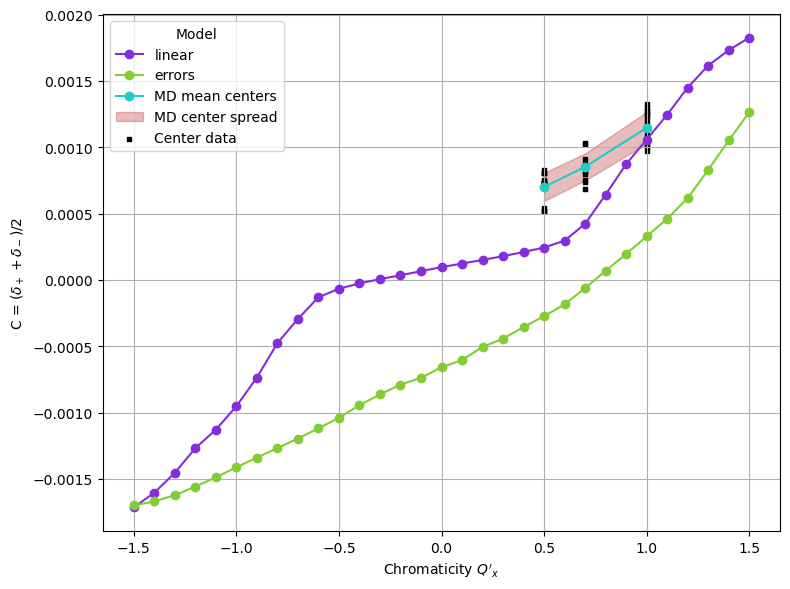

In [ ]:
# intensity_midpoints = get_midpoints(normalised_intensity)
# plot_centers(intensity_midpoints=intensity_midpoints, md_midpoints=midpoints_md)

In [95]:
# -----------------------
# Shared helpers (pure)
# -----------------------

def _default_line_types(intensity_midpoints):
    return list(intensity_midpoints.keys())

def _default_chromas(intensity_midpoints, line_types):
    lt0 = line_types[0]
    return sorted(intensity_midpoints[lt0].keys())

def _validate_md_structure(md_midpoints):
    if md_midpoints is None:
        return
    first_key = next(iter(md_midpoints.keys()))
    if first_key in ("pos", "neg"):
        raise ValueError(
            "md_midpoints has wrong structure (starts with 'pos'/'neg'). "
            "Apply restructure_md_midpoints first."
        )

def _make_default_style(line_types, md_midpoints, colours=None, markers=None):
    if colours is None:
        colours = {}
        n = len(line_types) + (2 if md_midpoints is not None else 0)
        colour_list = random_distinct_colors(n)
        for i, lt in enumerate(line_types):
            colours[lt] = colour_list[i]
        if md_midpoints is not None:
            colours["MD_means"] = colour_list[-2]
            colours["MD_stds"]  = colour_list[-1]

    if markers is None:
        markers = {lt: "o" for lt in line_types}
        if md_midpoints is not None:
            markers["MD_data"]  = "s"
            markers["MD_means"] = "o"

    return colours, markers


# -----------------------
# Center-specific helpers
# -----------------------

def _centers_vs_chroma_for_line(intensity_midpoints, line_type, chromas=None):
    by_chroma = intensity_midpoints[line_type]
    chroma_list = sorted(by_chroma.keys()) if chromas is None else sorted(chromas)

    xs, ys = [], []
    for c in chroma_list:
        if c not in by_chroma:
            continue
        dp = by_chroma[c]
        ys.append(get_center(dp.get("DPpos", np.nan), dp.get("DPneg", np.nan)))
        xs.append(float(c))

    return np.asarray(xs, float), np.asarray(ys, float)

def _md_centers_from_combinations(md_midpoints):
    centers_md = {}
    xs_all, ys_all = [], []

    for c, d in md_midpoints.items():
        combos = get_measurements_combinations(d["DPpos"], d["DPneg"])
        pts = np.array([get_center(plus, minus) for (plus, minus) in combos], dtype=float)

        centers_md[c] = {
            "points": pts,
            "mean": float(np.mean(pts)) if pts.size else np.nan,
            "std": float(np.std(pts, ddof=0)) if pts.size else np.nan,
        }

        if pts.size:
            xs_all.append(np.full(pts.shape, float(c)))
            ys_all.append(pts)

    xs = np.concatenate(xs_all) if xs_all else np.array([], dtype=float)
    ys = np.concatenate(ys_all) if ys_all else np.array([], dtype=float)
    return centers_md, xs, ys


# ---------------------------
# Acceptance-specific helpers
# ---------------------------

def _acceptance_vs_chroma_for_line(intensity_midpoints, line_type, chromas=None):
    """
    acceptance = delta_plus - delta_minus
    Expects delta_minus possibly negative already; the formula matches your definition.
    """
    by_chroma = intensity_midpoints[line_type]
    chroma_list = sorted(by_chroma.keys()) if chromas is None else sorted(chromas)

    xs, ys = [], []
    for c in chroma_list:
        if c not in by_chroma:
            continue
        dp = by_chroma[c]
        ys.append(get_acceptance(dp.get("DPpos", np.nan), dp.get("DPneg", np.nan)))
        xs.append(float(c))

    return np.asarray(xs, float), np.asarray(ys, float)

def _md_acceptance_from_combinations(md_midpoints):
    """
    Build acceptance points from all DPpos x DPneg combinations per chroma.
    acceptance = delta_plus - delta_minus
    """
    acc_md = {}
    xs_all, ys_all = [], []

    for c, d in md_midpoints.items():
        combos = get_measurements_combinations(d["DPpos"], d["DPneg"])
        pts = np.array([get_acceptance(plus, minus) for (plus, minus) in combos], dtype=float)

        acc_md[c] = {
            "points": pts,
            "mean": float(np.mean(pts)) if pts.size else np.nan,
            "std": float(np.std(pts, ddof=0)) if pts.size else np.nan,
        }

        if pts.size:
            xs_all.append(np.full(pts.shape, float(c)))
            ys_all.append(pts)

    xs = np.concatenate(xs_all) if xs_all else np.array([], dtype=float)
    ys = np.concatenate(ys_all) if ys_all else np.array([], dtype=float)
    return acc_md, xs, ys


# -----------------------
# Main plot functions
# -----------------------

def plot_centers(
    intensity_midpoints,
    *,
    line_types=None,
    chromas=None,
    colours=None,
    markers=None,
    md_midpoints=None,
    md_point_color="k",
    md_point_size=6,
    md_point_alpha=0.7,
    band_alpha=0.25,
    savefig=None
):
    _validate_md_structure(md_midpoints)

    if line_types is None:
        line_types = _default_line_types(intensity_midpoints)
    if chromas is None:
        chromas = _default_chromas(intensity_midpoints, line_types)

    colours, markers = _make_default_style(line_types, md_midpoints, colours, markers)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    for lt in line_types:
        x, y = _centers_vs_chroma_for_line(intensity_midpoints, lt, chromas=chromas)
        ax.plot(
            x, y,
            color=colours.get(lt, None),
            marker=markers.get(lt, "o"),
            linestyle="-",
            label=str(lt),
            zorder=3,
        )

    if md_midpoints is not None:
        centers_md, xs, ys = _md_centers_from_combinations(md_midpoints)

        ax.scatter(
            xs, ys,
            color=md_point_color,
            marker=markers.get("MD_data", "s"),
            s=md_point_size,
            alpha=md_point_alpha,
            label="MD samples",
            zorder=2,
        )

        md_chromas = np.array(sorted(centers_md.keys()), dtype=float)
        md_means = np.array([centers_md[c]["mean"] for c in md_chromas], dtype=float)
        md_stds  = np.array([centers_md[c]["std"]  for c in md_chromas], dtype=float)

        ax.plot(
            md_chromas, md_means,
            color=colours["MD_means"],
            marker=markers.get("MD_means", "o"),
            linestyle="-",
            label="MD mean",
            zorder=4,
        )

        ax.fill_between(
            md_chromas,
            md_means - md_stds,
            md_means + md_stds,
            color=colours["MD_stds"],
            alpha=band_alpha,
            label=r"MD $\pm 1\sigma$",
            zorder=1,
            linewidth=0,
        )

    ax.grid(alpha=0.3)
    ax.set_xlabel(r"Chromaticity $Q'_x$")
    ax.set_ylabel(r"Center $C = (\delta_+ + \delta_-)/2$")
    ax.legend(title="Model", fontsize=9)
    fig.tight_layout()

    if savefig is not None:
        figures_path = os.path.join(os.getcwd(), "Figures")

        if os.path.isdir(figures_path):
            plt.savefig(os.path.join(figures_path, savefig), dpi=300)
        else:
            plt.savefig(savefig, dpi=300)
    return fig, ax


def plot_acceptance(
    intensity_midpoints,
    *,
    line_types=None,
    chromas=None,
    colours=None,
    markers=None,
    md_midpoints=None,
    md_point_color="k",
    md_point_size=6,
    md_point_alpha=0.7,
    band_alpha=0.25,
    savefig=None
):
    """
    Same plotting style as plot_centers, but for:
      acceptance = delta_plus - delta_minus
    """
    _validate_md_structure(md_midpoints)

    if line_types is None:
        line_types = _default_line_types(intensity_midpoints)
    if chromas is None:
        chromas = _default_chromas(intensity_midpoints, line_types)

    colours, markers = _make_default_style(line_types, md_midpoints, colours, markers)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # ---- Simulation/model curves ----
    for lt in line_types:
        x, y = _acceptance_vs_chroma_for_line(intensity_midpoints, lt, chromas=chromas)
        ax.plot(
            x, y,
            color=colours.get(lt, None),
            marker=markers.get(lt, "o"),
            linestyle="-",
            label=str(lt),
            zorder=3,
        )

    # ---- MD overlay ----
    if md_midpoints is not None:
        acc_md, xs, ys = _md_acceptance_from_combinations(md_midpoints)

        ax.scatter(
            xs, ys,
            color=md_point_color,
            marker=markers.get("MD_data", "s"),
            s=md_point_size,
            alpha=md_point_alpha,
            label="MD samples",
            zorder=2,
        )

        md_chromas = np.array(sorted(acc_md.keys()), dtype=float)
        md_means = np.array([acc_md[c]["mean"] for c in md_chromas], dtype=float)
        md_stds  = np.array([acc_md[c]["std"]  for c in md_chromas], dtype=float)

        ax.plot(
            md_chromas, md_means,
            color=colours["MD_means"],
            marker=markers.get("MD_means", "o"),
            linestyle="-",
            label="MD mean",
            zorder=4,
        )

        ax.fill_between(
            md_chromas,
            md_means - md_stds,
            md_means + md_stds,
            color=colours["MD_stds"],
            alpha=band_alpha,
            label=r"MD $\pm 1\sigma$",
            zorder=1,
            linewidth=0,
        )

    ax.grid(alpha=0.3)
    ax.set_xlabel(r"Chromaticity $Q'_x$")
    ax.set_ylabel(r"Acceptance $A = \delta_+ - \delta_-$")
    ax.legend(title="Model", fontsize=9)
    fig.tight_layout()

    if savefig is not None:
        figures_path = os.path.join(os.getcwd(), "Figures")

        if os.path.isdir(figures_path):
            plt.savefig(os.path.join(figures_path, savefig), dpi=300)
        else:
            plt.savefig(savefig, dpi=300)
    return fig, ax

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel="Chromaticity $Q'_x$", ylabel='Acceptance $A = \\delta_+ - \\delta_-$'>)

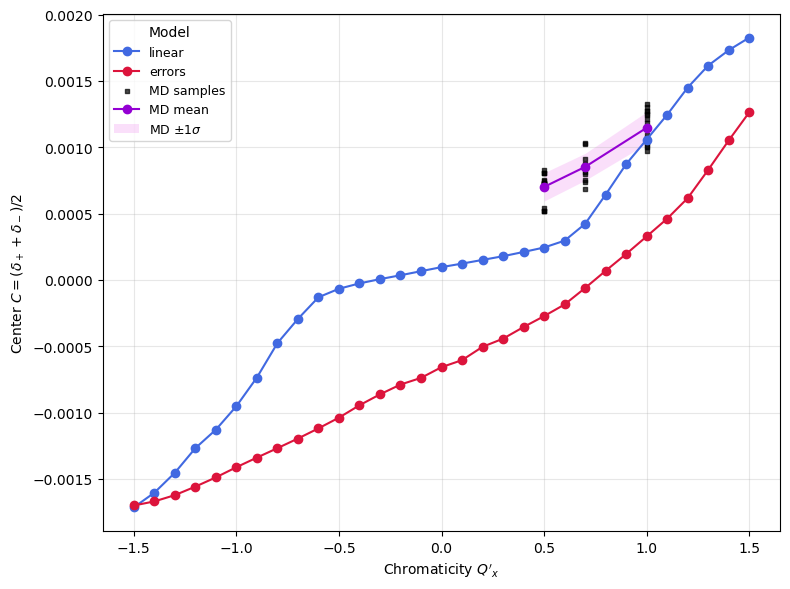

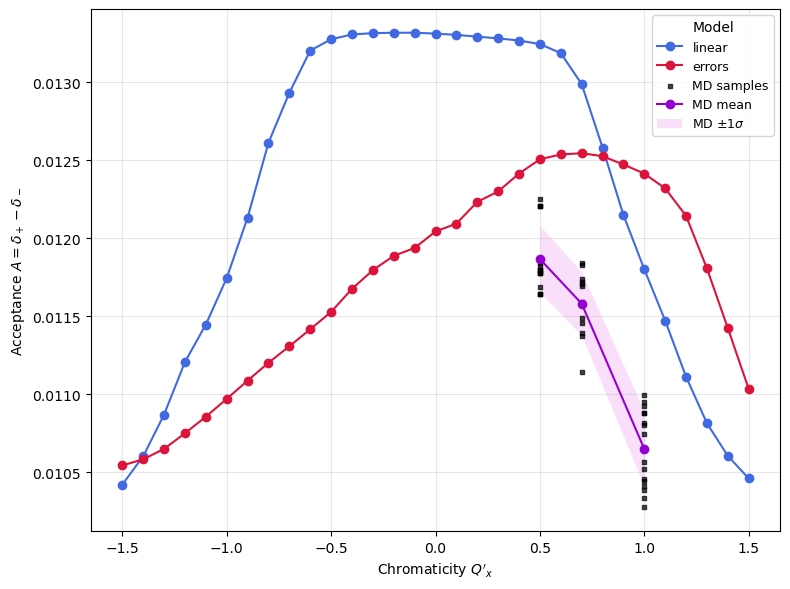

In [97]:
colours = {'linear' : 'royalblue', 'errors': 'crimson', 'MD_means' : 'darkviolet', 'MD_stds' : 'violet'}
intensity_midpoints = get_midpoints(normalised_intensity)
plot_centers(intensity_midpoints=intensity_midpoints, colours= colours, md_midpoints=midpoints_md, savefig='centers_vs_chroma.png')
plot_acceptance(intensity_midpoints, colours= colours, md_midpoints=midpoints_md, savefig='acceptance_vs_chroma.png')